Ordinal regression
--
Ordinal regression aims to fit a model to some data $(X, Y)$, where $Y$ is an ordinal variable. To do so, we use a `VPG` model with a specific likelihood (`gpflow.likelihoods.Ordinal`).

In [9]:
import gpflow

import tensorflow as tf
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

Text(0, 0.5, 'observed data value')

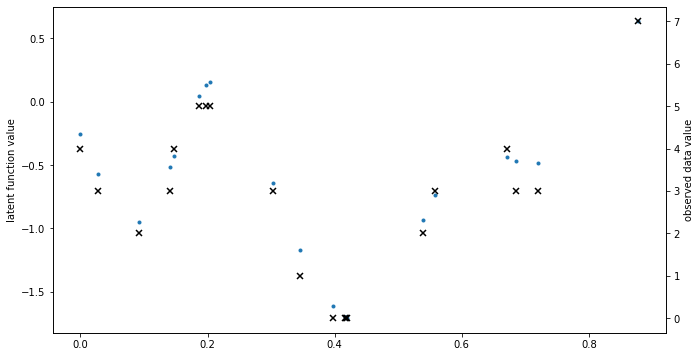

In [10]:
# make a one-dimensional ordinal regression problem

# This function generates a set of inputs X, 
# quantitative output f (latent) and ordinal values Y

def generate_data(num_data):
    # First generate random inputs
    X = np.random.rand(num_data, 1)
    
    # Now generate values of a latent GP
    kern = gpflow.kernels.SquaredExponential(lengthscale=0.1)
    K = kern(X)
    f = np.random.multivariate_normal(mean=np.zeros(num_data), cov=K).reshape(-1, 1)
    
    # Finally convert f values into ordinal values Y
    Y = np.round((f + f.min())*3)
    Y = Y - Y.min()
    Y = np.asarray(Y, np.float64)

    return X, f, Y

np.random.seed(1)
num_data = 20
X, f, Y = generate_data(num_data)

plt.figure(figsize=(11, 6))
plt.plot(X, f, '.')
plt.ylabel('latent function value')

plt.twinx()
plt.plot(X, Y, 'kx', mew=1.5)
plt.ylabel('observed data value')

In [13]:
# construct ordinal likelihood - bin_edges is the same as unique(Y) but centered
bin_edges = np.array(np.arange(np.unique(Y).size + 1), dtype=float)
bin_edges = bin_edges - bin_edges.mean()
likelihood= gpflow.likelihoods.Ordinal(bin_edges)

# build a model with this likelihood
m = gpflow.models.VGP(data=(X, Y), 
                      kernel=gpflow.kernels.Matern32(),
                      likelihood=likelihood)

# fit the model
# @tf.function
def objective_closure():
    return - m.log_marginal_likelihood()

opt = gpflow.optimizers.Scipy()
opt.minimize(objective_closure, m.trainable_variables, options=dict(maxiter=100))

W0913 14:50:54.109915 140233136760640 deprecation.py:323] From /home/sergio.diaz/gpflowopt_env/lib/python3.6/site-packages/tensorflow_core/python/ops/array_grad.py:562: _EagerTensorBase.cpu (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.identity instead.


      fun: 29.05646113189765
 hess_inv: array([[ 2.18876725e-01,  2.26115463e+00, -1.59103603e-02, ...,
         2.09923249e-02,  3.05183567e-02, -9.31680620e-03],
       [ 2.26115463e+00,  3.27424400e+01, -1.78035918e-01, ...,
         2.05957773e-01,  3.11460860e-01, -1.69233821e-01],
       [-1.59103603e-02, -1.78035918e-01,  3.44531241e-01, ...,
         8.26861775e-03, -2.29758357e-03,  3.60079193e-02],
       ...,
       [ 2.09923249e-02,  2.05957773e-01,  8.26861775e-03, ...,
         1.34628502e-01,  2.60450262e-03,  6.18350744e-03],
       [ 3.05183567e-02,  3.11460860e-01, -2.29758357e-03, ...,
         2.60450262e-03,  1.30094714e-01, -1.69540454e-03],
       [-9.31680620e-03, -1.69233821e-01,  3.60079193e-02, ...,
         6.18350744e-03, -1.69540454e-03,  3.72500021e-02]])
      jac: array([-2.32849289e-05, -9.23868989e-06,  3.73807064e-06,  3.74215141e-05,
       -1.48551597e-05, -9.18820995e-06,  2.13436363e-05,  4.90202019e-06,
        7.06307941e-06, -5.60568669e-06,  

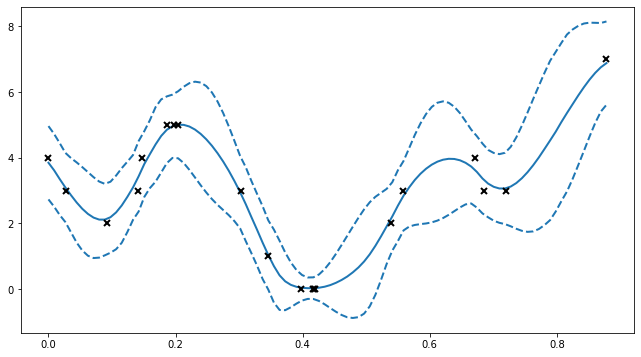

In [19]:
# here we'll plot the expected value of Y +- 2 std deviations, as if the distribution were Gaussian
plt.figure(figsize=(11, 6))
x_data, y_data = m.data
Xtest = np.linspace(x_data.min(), x_data.max(), 100).reshape(-1, 1)
mu, var = m.predict_y(Xtest)
line, = plt.plot(Xtest, mu, lw=2)
col=line.get_color()
plt.plot(Xtest, mu+2*np.sqrt(var), '--', lw=2, color=col)
plt.plot(Xtest, mu-2*np.sqrt(var), '--', lw=2, color=col)
plt.plot(x_data, y_data, 'kx', mew=2)

In [28]:
## to see the predictive density, try predicting every possible discrete value for Y.
def pred_log_density(m):
    Xtest = np.linspace(x_data.min(), x_data.max(), 100).reshape(-1, 1)
    ys = np.arange(y_data.max()+1)
    densities = []
    for y in ys:
        Ytest = np.ones_like(Xtest) * y
        # Predict the log density
        densities.append(m.predict_log_density((Xtest, Ytest)))
    return np.hstack(densities).T

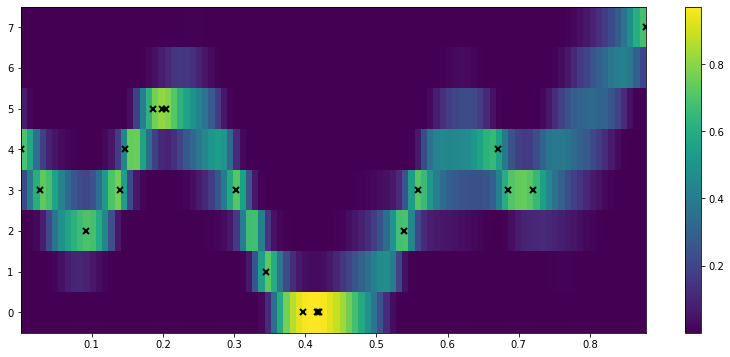

In [29]:
fig = plt.figure(figsize=(14, 6))
plt.imshow(np.exp(pred_log_density(m)), interpolation='nearest',
           extent=[x_data.min(), x_data.max(), -0.5,y_data.max()+0.5],
           origin='lower', aspect='auto', cmap=plt.cm.viridis)
plt.colorbar()
plt.plot(X, Y, 'kx', mew=2, scalex=False, scaley=False)

<BarContainer object of 8 artists>

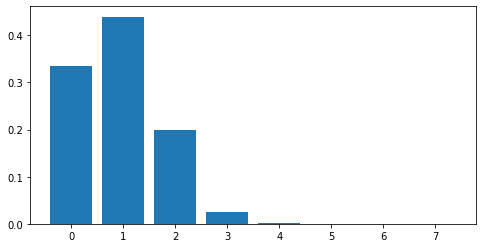

In [34]:
# Predictive density for a single input x=0.5
x_new = 0.5
ys = np.arange(np.max(y_data+1)).reshape([-1, 1])
x_new_vec = x_new*np.ones_like(ys)
# for predict_density x and y need to have the same number of rows
dens_new = np.exp(m.predict_log_density((x_new_vec, ys)))
fig = plt.figure(figsize=(8, 4))
plt.bar(x=ys.flatten(), height=dens_new.flatten())